# COVID-19 Forecasting Prediction using Auto ARIMA Model

### The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis.



In [1]:
library(tidyverse)
library(timeSeries)
library(dplyr) 
library(caret)
library(ggplot2)
library(forecast)
library(lubridate)
library(ModelMetrics)
set.seed(123) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: timeDate

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date



Attaching package: ‘ModelMetrics’


The following objects are masked from ‘package:caret’:

    confusionMatrix, precision, recall, sensitivit

In [2]:
## Reading in files
covid_data_train = read.csv('../input/covid19-global-forecasting-week-4/train.csv')
covid_data_test = read.csv('../input/covid19-global-forecasting-week-4/test.csv')
covid_data_submission = read.csv('../input/covid19-global-forecasting-week-4/submission.csv')

## Analysising and Cleaning the data

In [3]:
str(covid_data_train)

'data.frame':	25040 obs. of  6 variables:
 $ Id            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Province_State: Factor w/ 134 levels "","Alabama","Alaska",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Country_Region: Factor w/ 184 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Date          : Factor w/ 80 levels "2020-01-22","2020-01-23",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ConfirmedCases: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Fatalities    : num  0 0 0 0 0 0 0 0 0 0 ...


In [4]:
str(covid_data_test)

'data.frame':	13459 obs. of  4 variables:
 $ ForecastId    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Province_State: Factor w/ 134 levels "","Alabama","Alaska",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Country_Region: Factor w/ 184 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Date          : Factor w/ 43 levels "2020-04-02","2020-04-03",..: 1 2 3 4 5 6 7 8 9 10 ...


In [5]:
str(covid_data_submission)

'data.frame':	13459 obs. of  3 variables:
 $ ForecastId    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ ConfirmedCases: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Fatalities    : int  1 1 1 1 1 1 1 1 1 1 ...


In [6]:
# Converting factor datatypes to character
covid_data_train[["Province_State"]] <- as.character(covid_data_train[["Province_State"]] )
covid_data_train[["Country_Region"]] <- as.character(covid_data_train[["Country_Region"]] )
str(covid_data_train)

'data.frame':	25040 obs. of  6 variables:
 $ Id            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Province_State: chr  "" "" "" "" ...
 $ Country_Region: chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Date          : Factor w/ 80 levels "2020-01-22","2020-01-23",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ConfirmedCases: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Fatalities    : num  0 0 0 0 0 0 0 0 0 0 ...


In [7]:
covid_data_test[["Province_State"]] <- as.character(covid_data_test[["Province_State"]] )
covid_data_test[["Country_Region"]] <- as.character(covid_data_test[["Country_Region"]] )
str(covid_data_test)

'data.frame':	13459 obs. of  4 variables:
 $ ForecastId    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Province_State: chr  "" "" "" "" ...
 $ Country_Region: chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Date          : Factor w/ 43 levels "2020-04-02","2020-04-03",..: 1 2 3 4 5 6 7 8 9 10 ...


In [8]:
# convert date from categorical to Date format
covid_data_train[["Date"]] <- as.Date(covid_data_train[["Date"]], format = "%Y-%m-%d")
covid_data_test[["Date"]] <- as.Date(covid_data_test[["Date"]], format = "%Y-%m-%d")
str(covid_data_train)

'data.frame':	25040 obs. of  6 variables:
 $ Id            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Province_State: chr  "" "" "" "" ...
 $ Country_Region: chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Date          : Date, format: "2020-01-22" "2020-01-23" ...
 $ ConfirmedCases: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Fatalities    : num  0 0 0 0 0 0 0 0 0 0 ...


In [9]:
# Some of the Province State are missing, to replace the missing Province States with their Country.
covid_data_train[["Province_State"]] <- ifelse(covid_data_train[["Province_State"]] == "", covid_data_train[["Country_Region"]], covid_data_train[["Province_State"]])
covid_data_test[["Province_State"]] <- ifelse(covid_data_test[["Province_State"]] == "", covid_data_test[["Country_Region"]], covid_data_test[["Province_State"]])

In [10]:
head(covid_data_train)
tail(covid_data_train)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
,<int>,<chr>,<chr>,<date>,<dbl>,<dbl>
1,1,Afghanistan,Afghanistan,2020-01-22,0,0
2,2,Afghanistan,Afghanistan,2020-01-23,0,0
3,3,Afghanistan,Afghanistan,2020-01-24,0,0
4,4,Afghanistan,Afghanistan,2020-01-25,0,0
5,5,Afghanistan,Afghanistan,2020-01-26,0,0
6,6,Afghanistan,Afghanistan,2020-01-27,0,0


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
,<int>,<chr>,<chr>,<date>,<dbl>,<dbl>
25035,35643,Zimbabwe,Zimbabwe,2020-04-05,9,1
25036,35644,Zimbabwe,Zimbabwe,2020-04-06,10,1
25037,35645,Zimbabwe,Zimbabwe,2020-04-07,11,2
25038,35646,Zimbabwe,Zimbabwe,2020-04-08,11,3
25039,35647,Zimbabwe,Zimbabwe,2020-04-09,11,3
25040,35648,Zimbabwe,Zimbabwe,2020-04-10,13,3


In [11]:
# show variables with missing values
colSums(is.na(covid_data_train)) 
colSums(is.na(covid_data_test)) 
sum(is.na(covid_data_train))

# 0 missing values

Id Province_State Country_Region           Date ConfirmedCases 
             0              0              0              0              0 
    Fatalities 
             0

ForecastId Province_State Country_Region           Date 
             0              0              0              0

[1] 0

## Exploratory Data Analysis(EDA)

#### Covid-19 Confirmed & Fatalities Cases with Date

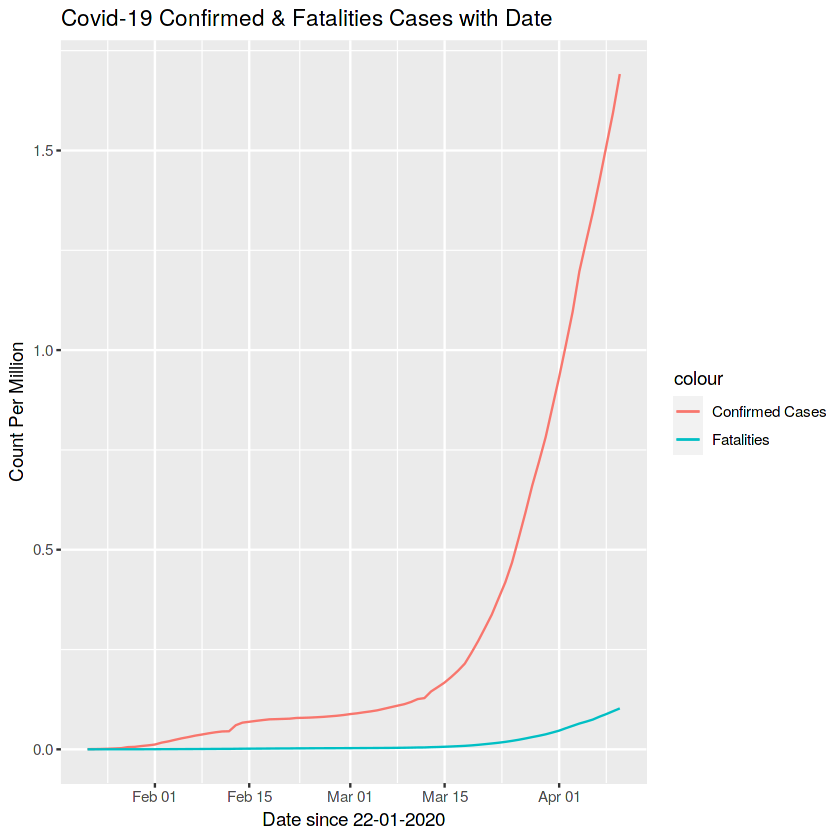

In [12]:
# cummulative the Train data by Date
covidCummulativeData <- covid_data_train %>% 
  group_by(Date) %>%
  summarise(ConfirmedCases = sum(ConfirmedCases), Fatalities = sum(Fatalities))


ggplot(covidCummulativeData, aes(Date)) + 
  geom_line(aes(y = ConfirmedCases/1000000, colour = "Confirmed Cases")) + 
  geom_line(aes(y = Fatalities/1000000, colour = "Fatalities")) + 
  labs(x = 'Date since 22-01-2020', y = 'Count Per Million') +
  ggtitle("Covid-19 Confirmed & Fatalities Cases with Date")

#### Progress of Covid-19 Confirmed and Fatalities Cases with Dates for few countries

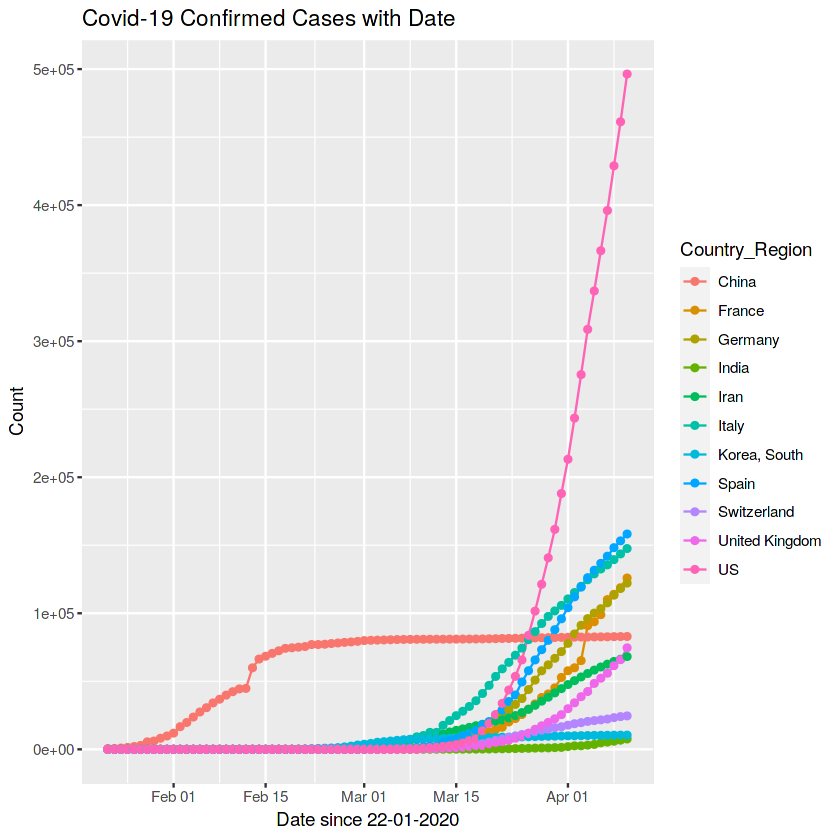

In [13]:
# Group the Train data by Country and Date
covidFilterData <- covid_data_train %>%
  dplyr::filter(Country_Region %in% c("China","Italy","US","Germany","Iran","Spain","France","Korea, South","Switzerland","United Kingdom","India")) %>%
  group_by(Date, Country_Region) %>%
  summarise(ConfirmedCases = sum(ConfirmedCases), Fatalities = sum(Fatalities))

# visualize the confirmed cases of few countries
ggplot(data = covidFilterData, aes(x = Date, y = ConfirmedCases, group = Country_Region)) +
  geom_line(aes(color = Country_Region)) + 
  labs(x = 'Date since 22-01-2020', y = 'Count') + 
  geom_point(aes(color=Country_Region))+
  ggtitle("Covid-19 Confirmed Cases with Date") 

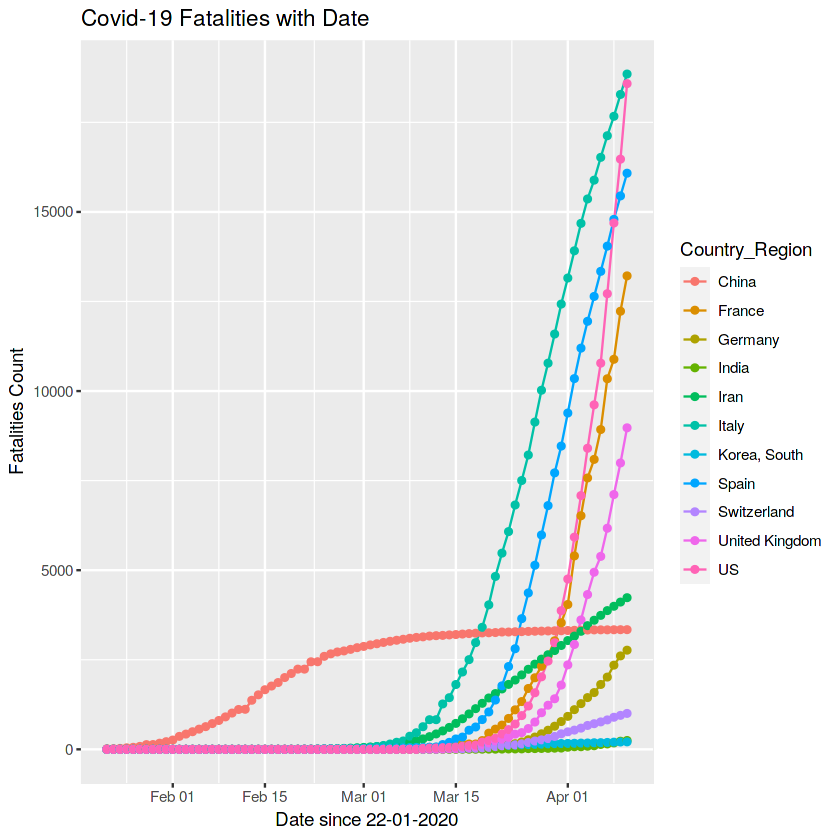

In [14]:
# visualize the Fatalities cases of few countries
ggplot(data = covidFilterData, aes(x = Date, y = Fatalities, group = Country_Region)) +
  geom_line(aes(color = Country_Region)) + 
  labs(x = 'Date since 22-01-2020', y = 'Fatalities Count') + 
  geom_point(aes(color=Country_Region))+
  ggtitle("Covid-19 Fatalities with Date") 

#### visualize the Confirmed Cases vs Fatalities cases of few countries

Date,Country_Region,event,total
<date>,<chr>,<chr>,<dbl>
2020-01-22,China,ConfirmedCases,548
2020-01-22,France,ConfirmedCases,0
2020-01-22,Germany,ConfirmedCases,0
2020-01-22,India,ConfirmedCases,0
2020-01-22,Iran,ConfirmedCases,0
2020-01-22,Italy,ConfirmedCases,0


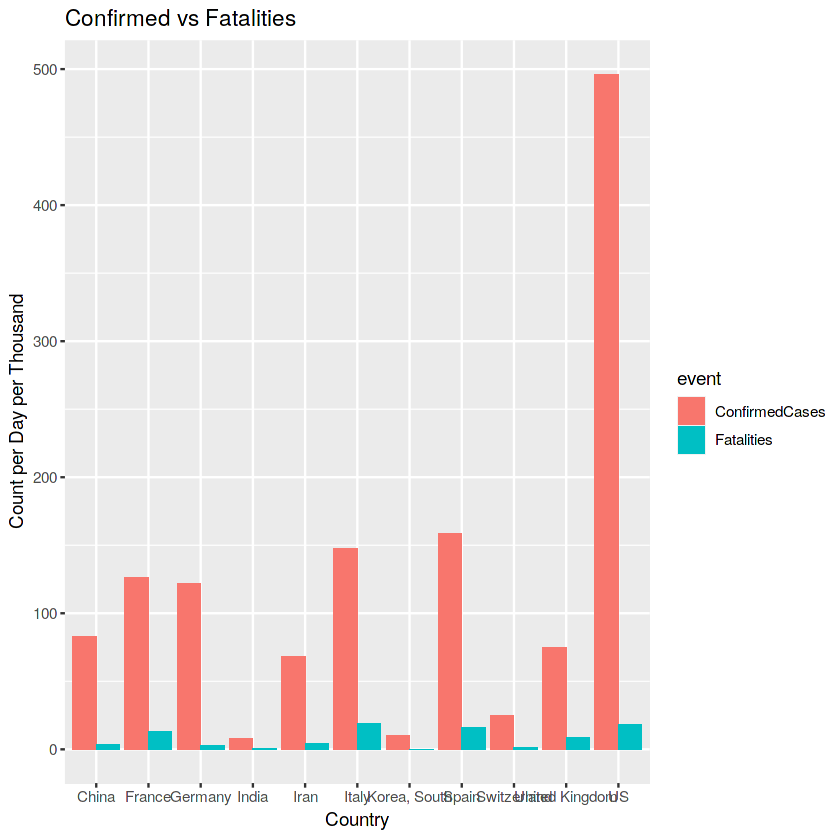

In [15]:
#Create long format
longFrmtData <- gather(covidFilterData, event, total, ConfirmedCases:Fatalities) 
head(longFrmtData)

ggplot(longFrmtData, aes(Country_Region, total/1000, fill=event)) + 
  geom_bar(stat = "identity", position = 'dodge') + 
  labs(x="Country",y="Count per Day per Thousand") + 
  ggtitle("Confirmed vs Fatalities")


#### Confirmed Cases: 
It can be seen that a raise in maximum number of new cases appears in week of Feb 11-18, after which China reached its saturation point. Then a new sudden rise appears after March 24th, when the total new cases world wide crosses the total affectees in China alone.

#### Deaths: 
As can be seen, since March 11th, the death toll rises steeply due to extreme rise in European countires, specially Italy, Spain, France and UK, and as well as now in US. The average mortality rate in these countries below can explain the peaks in the global mortality rate.

## ARIMA Time Series Analysis and Forecasting 

We need to do the predictions for 43 days, with overlap with of 9 days in training data that we will use to test our forecast model. Lets look at the records with entries greater than zero.

In [16]:
unique_state_train <- covid_data_train %>% distinct(Province_State)
head(unique_state_train)

state_len <- length(unique_state_train$Province_State)
cat("Count of unique Province States:", state_len, "\n")

,Province_State
,<chr>
1,Afghanistan
2,Albania
3,Algeria
4,Andorra
5,Angola
6,Antigua and Barbuda


Count of unique Province States: 312 


In [17]:
## Foresting

for(states in 1:state_len){

  cat(states, "/", state_len, "Province:", unique_state_train[["Province_State"]][states], "\n")

  train <- covid_data_train %>% dplyr::filter(covid_data_train[["Province_State"]] == unique_state_train[["Province_State"]][states] ) %>%
    arrange(Date) 
  
  test <- covid_data_test %>% dplyr::filter(covid_data_test[["Province_State"]] == unique_state_train[["Province_State"]][states]) %>%
    arrange(Date)
  
  
  ## Confirm Case Forecasting
  
  if (all(train$ConfirmedCases == 0)) {
    
    covid_data_submission[["ConfirmedCases"]][covid_data_submission[["ForecastId"]] %in% test[["ForecastId"]]] <- 0
    covid_data_submission[["Fatalities"]][covid_data_submission[["ForecastId"]] %in% test[["ForecastId"]]] <- 0
    
    next()
    
  } else {
    
    ts.cc.train <- ts(train$ConfirmedCases, start = decimal_date(as.Date("2020-01-22")), frequency = 365.25)
    
    fit.cc <-  Arima(ts.cc.train, order = c(2,2,2), seasonal = list(order = c(1,1,0), period = 12), method = "ML",
                     optim.method = "BFGS")
    
    
    forecast.cc <- forecast(fit.cc, h=43, level=c(99.5))
    
    for(i in 1:43){
      test$ConfirmedCases[i] <- ifelse(forecast.cc[["upper"]][i] > 0, as.numeric(round(forecast.cc[["upper"]][i])), 0)
    }
    
    covid_data_submission[["ConfirmedCases"]][covid_data_submission[["ForecastId"]] %in% test[["ForecastId"]]] <-
      ifelse(forecast.cc[["upper"]] > 0, round(forecast.cc[["upper"]]), 0)
    
    rm(forecast.cc)
  }

  ### Fatalities Forecasting
  
  if (all(train$Fatalities == 0)) {
    
    covid_data_submission[["Fatalities"]][covid_data_submission[["ForecastId"]] %in% test[["ForecastId"]]] <- 0
    next()
    
  } else {
    
    fit.fat <- train(form=as.formula("Fatalities ~ ConfirmedCases"),
                     data = train,
                     method = "bayesglm",
                     trControl=trainControl(method="repeatedcv", number=8, repeats=5))
    
    preds <- predict(fit.fat, test)
    test$Fatalities <- ifelse(preds > 0, as.numeric(round(preds)), 0)
    covid_data_submission[["Fatalities"]][covid_data_submission[["ForecastId"]] %in% test[["ForecastId"]]] <- ifelse(preds > 0, round(preds), 0)
    
    preds2 <- predict(fit.fat, train)
    preds2[preds2 < 0] <- 0
    cat("RMSLE :-  ", round(rmsle(train$Fatalities, preds2), 4), "\n\n")
    
    rm(preds)
    rm(preds2)
    
  }
  
}


1 / 312 Province: Afghanistan 
RMSLE :-   0.158 

2 / 312 Province: Albania 
RMSLE :-   0.1822 

3 / 312 Province: Algeria 
RMSLE :-   0.267 

4 / 312 Province: Andorra 
RMSLE :-   0.3892 

5 / 312 Province: Angola 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1688 

6 / 312 Province: Antigua and Barbuda 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1741 

7 / 312 Province: Argentina 
RMSLE :-   0.2834 

8 / 312 Province: Armenia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.321 

9 / 312 Province: Australian Capital Territory 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1835 

10 / 312 Province: New South Wales 
RMSLE :-   0.3783 

11 / 312 Province: Northern Territory 
12 / 312 Province: Queensland 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.223 

13 / 312 Province: South Australia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2357 

14 / 312 Province: Tasmania 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2341 

15 / 312 Province: Victoria 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3419 

16 / 312 Province: Western Australia 
RMSLE :-   0.2815 

17 / 312 Province: Austria 
RMSLE :-   0.5193 

18 / 312 Province: Azerbaijan 
RMSLE :-   0.2227 

19 / 312 Province: Bahamas 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3117 

20 / 312 Province: Bahrain 
RMSLE :-   0.2348 

21 / 312 Province: Bangladesh 
RMSLE :-   0.2994 

22 / 312 Province: Barbados 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.264 

23 / 312 Province: Belarus 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2668 

24 / 312 Province: Belgium 
RMSLE :-   0.5871 

25 / 312 Province: Belize 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1153 

26 / 312 Province: Benin 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1028 

27 / 312 Province: Bhutan 
28 / 312 Province: Bolivia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3962 

29 / 312 Province: Bosnia and Herzegovina 
RMSLE :-   0.306 

30 / 312 Province: Botswana 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0982 

31 / 312 Province: Brazil 
RMSLE :-   0.291 

32 / 312 Province: Brunei 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1644 

33 / 312 Province: Bulgaria 
RMSLE :-   0.2685 

34 / 312 Province: Burkina Faso 
RMSLE :-   0.1257 

35 / 312 Province: Burma 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1536 

36 / 312 Province: Burundi 
37 / 312 Province: Cabo Verde 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.093 

38 / 312 Province: Cambodia 
39 / 312 Province: Cameroon 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2425 

40 / 312 Province: Alberta 
RMSLE :-   0.3847 

41 / 312 Province: British Columbia 
RMSLE :-   0.1556 

42 / 312 Province: Manitoba 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1019 

43 / 312 Province: New Brunswick 
44 / 312 Province: Newfoundland and Labrador 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1329 

45 / 312 Province: Northwest Territories 
46 / 312 Province: Nova Scotia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1341 

47 / 312 Province: Ontario 
RMSLE :-   0.3262 

48 / 312 Province: Prince Edward Island 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 1 set to min.prior.scale = 1e-12
”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 2 set to min.prior.scale = 1e-12
”
Warning message:
“model fit failed for Fold8.Rep1: parameter=none Error in lm.fit(x = x.star[good.star, , drop = FALSE] * w.star, y = z.star *  : 
  NA/NaN/Inf in 'x'
”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 1 set to min.prior.scale = 1e-12
”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 2 set to min.prior.scale = 1e-12
”
Warning message:
“model fit failed f

RMSLE :-   0.0741 

49 / 312 Province: Quebec 
RMSLE :-   0.401 

50 / 312 Province: Saskatchewan 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2234 

51 / 312 Province: Yukon 
52 / 312 Province: Central African Republic 
53 / 312 Province: Chad 
54 / 312 Province: Chile 
RMSLE :-   0.3562 

55 / 312 Province: Anhui 
RMSLE :-   0.3856 

56 / 312 Province: Beijing 
RMSLE :-   0.2938 

57 / 312 Province: Chongqing 
RMSLE :-   0.1924 

58 / 312 Province: Fujian 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”


RMSLE :-   0.2366 

59 / 312 Province: Gansu 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2353 

60 / 312 Province: Guangdong 
RMSLE :-   0.5024 

61 / 312 Province: Guangxi 
RMSLE :-   0.1989 

62 / 312 Province: Guizhou 
RMSLE :-   0.1321 

63 / 312 Province: Hainan 
RMSLE :-   0.1946 

64 / 312 Province: Hebei 
RMSLE :-   0.2886 

65 / 312 Province: Heilongjiang 
RMSLE :-   0.2203 

66 / 312 Province: Henan 
RMSLE :-   0.4471 

67 / 312 Province: Hong Kong 
RMSLE :-   0.43 

68 / 312 Province: Hubei 
RMSLE :-   1.3027 

69 / 312 Province: Hunan 
RMSLE :-   0.3415 

70 / 312 Province: Inner Mongolia 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”


RMSLE :-   0.2657 

71 / 312 Province: Jiangsu 
72 / 312 Province: Jiangxi 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1311 

73 / 312 Province: Jilin 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0911 

74 / 312 Province: Liaoning 
RMSLE :-   0.2474 

75 / 312 Province: Macau 
76 / 312 Province: Ningxia 
77 / 312 Province: Qinghai 
78 / 312 Province: Shaanxi 
RMSLE :-   0.466 

79 / 312 Province: Shandong 
RMSLE :-   0.3291 

80 / 312 Province: Shanghai 
RMSLE :-   0.3007 

81 / 312 Province: Shanxi 
82 / 312 Province: Sichuan 
RMSLE :-   0.1723 

83 / 312 Province: Tianjin 
RMSLE :-   0.1857 

84 / 312 Province: Tibet 
85 / 312 Province: Xinjiang 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3213 

86 / 312 Province: Yunnan 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.388 

87 / 312 Province: Zhejiang 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2496 

88 / 312 Province: Colombia 
RMSLE :-   0.3572 

89 / 312 Province: Congo (Brazzaville) 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2329 

90 / 312 Province: Congo (Kinshasa) 
RMSLE :-   0.2164 

91 / 312 Province: Costa Rica 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.16 

92 / 312 Province: Cote d'Ivoire 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1371 

93 / 312 Province: Croatia 
RMSLE :-   0.249 

94 / 312 Province: Cuba 
RMSLE :-   0.1079 

95 / 312 Province: Cyprus 
RMSLE :-   0.2576 

96 / 312 Province: Czechia 
RMSLE :-   0.7112 

97 / 312 Province: Faroe Islands 
98 / 312 Province: Greenland 
99 / 312 Province: Denmark 
RMSLE :-   0.8441 

100 / 312 Province: Diamond Princess 
RMSLE :-   0.5391 

101 / 312 Province: Djibouti 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 1 set to min.prior.scale = 1e-12
”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 2 set to min.prior.scale = 1e-12
”
Warning message:
“model fit failed for Fold7.Rep1: parameter=none Error in lm.fit(x = x.star[good.star, , drop = FALSE] * w.star, y = z.star *  : 
  NA/NaN/Inf in 'x'
”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 1 set to min.prior.scale = 1e-12
”
Warning message in bayesglm.fit(x = X, y = Y, weights = weights, start = start, :
“prior scale for varible 2 set to min.prior.scale = 1e-12
”
Warning message:
“model fit failed f

RMSLE :-   0.0682 

102 / 312 Province: Dominica 
103 / 312 Province: Dominican Republic 
RMSLE :-   0.2523 

104 / 312 Province: Ecuador 
RMSLE :-   0.3572 

105 / 312 Province: Egypt 
RMSLE :-   0.2915 

106 / 312 Province: El Salvador 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1778 

107 / 312 Province: Equatorial Guinea 
108 / 312 Province: Eritrea 
109 / 312 Province: Estonia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.6107 

110 / 312 Province: Eswatini 
111 / 312 Province: Ethiopia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2054 

112 / 312 Province: Fiji 
113 / 312 Province: Finland 
RMSLE :-   0.5687 

114 / 312 Province: French Guiana 
115 / 312 Province: French Polynesia 
116 / 312 Province: Guadeloupe 
RMSLE :-   0.2981 

117 / 312 Province: Martinique 
RMSLE :-   0.1678 

118 / 312 Province: Mayotte 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1405 

119 / 312 Province: New Caledonia 
120 / 312 Province: Reunion 
121 / 312 Province: Saint Barthelemy 
122 / 312 Province: Saint Pierre and Miquelon 
123 / 312 Province: St Martin 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1399 

124 / 312 Province: France 
RMSLE :-   1.0176 

125 / 312 Province: Gabon 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1929 

126 / 312 Province: Gambia 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0755 

127 / 312 Province: Georgia 
RMSLE :-   0.3553 

128 / 312 Province: Germany 
RMSLE :-   0.6316 

129 / 312 Province: Ghana 
RMSLE :-   0.198 

130 / 312 Province: Greece 
RMSLE :-   0.3397 

131 / 312 Province: Grenada 
132 / 312 Province: Guatemala 
RMSLE :-   0.1485 

133 / 312 Province: Guinea 
134 / 312 Province: Guinea-Bissau 
135 / 312 Province: Guyana 
RMSLE :-   0.165 

136 / 312 Province: Haiti 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1546 

137 / 312 Province: Holy See 
138 / 312 Province: Honduras 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3307 

139 / 312 Province: Hungary 
RMSLE :-   0.1813 

140 / 312 Province: Iceland 
RMSLE :-   0.2329 

141 / 312 Province: India 
RMSLE :-   0.1412 

142 / 312 Province: Indonesia 
RMSLE :-   0.2375 

143 / 312 Province: Iran 
RMSLE :-   0.7048 

144 / 312 Province: Iraq 
RMSLE :-   0.6626 

145 / 312 Province: Ireland 
RMSLE :-   0.5622 

146 / 312 Province: Israel 
RMSLE :-   0.3335 

147 / 312 Province: Italy 
RMSLE :-   1.119 

148 / 312 Province: Jamaica 
RMSLE :-   0.1434 

149 / 312 Province: Japan 
RMSLE :-   0.7593 

150 / 312 Province: Jordan 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3524 

151 / 312 Province: Kazakhstan 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2119 

152 / 312 Province: Kenya 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1438 

153 / 312 Province: Korea, South 
RMSLE :-   0.4271 

154 / 312 Province: Kosovo 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1756 

155 / 312 Province: Kuwait 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1027 

156 / 312 Province: Kyrgyzstan 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2432 

157 / 312 Province: Laos 
158 / 312 Province: Latvia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2184 

159 / 312 Province: Lebanon 
RMSLE :-   0.2015 

160 / 312 Province: Liberia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1762 

161 / 312 Province: Libya 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0927 

162 / 312 Province: Liechtenstein 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1553 

163 / 312 Province: Lithuania 
RMSLE :-   0.1364 

164 / 312 Province: Luxembourg 
RMSLE :-   0.1819 

165 / 312 Province: MS Zaandam 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0786 

166 / 312 Province: Madagascar 
167 / 312 Province: Malawi 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.081 

168 / 312 Province: Malaysia 
RMSLE :-   0.4811 

169 / 312 Province: Maldives 
170 / 312 Province: Mali 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1463 

171 / 312 Province: Malta 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1617 

172 / 312 Province: Mauritania 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1241 

173 / 312 Province: Mauritius 
RMSLE :-   0.1353 

174 / 312 Province: Mexico 
RMSLE :-   0.4034 

175 / 312 Province: Moldova 
RMSLE :-   0.2166 

176 / 312 Province: Monaco 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1116 

177 / 312 Province: Mongolia 
178 / 312 Province: Montenegro 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1104 

179 / 312 Province: Morocco 
RMSLE :-   0.2481 

180 / 312 Province: Mozambique 
181 / 312 Province: Namibia 
182 / 312 Province: Nepal 
183 / 312 Province: Aruba 
184 / 312 Province: Bonaire, Sint Eustatius and Saba 
185 / 312 Province: Curacao 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1339 

186 / 312 Province: Sint Maarten 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1649 

187 / 312 Province: Netherlands 
RMSLE :-   0.5075 

188 / 312 Province: New Zealand 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0924 

189 / 312 Province: Nicaragua 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1031 

190 / 312 Province: Niger 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2462 

191 / 312 Province: Nigeria 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1222 

192 / 312 Province: North Macedonia 
RMSLE :-   0.3146 

193 / 312 Province: Norway 
RMSLE :-   0.5743 

194 / 312 Province: Oman 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1596 

195 / 312 Province: Pakistan 
RMSLE :-   0.3101 

196 / 312 Province: Panama 
RMSLE :-   0.2417 

197 / 312 Province: Papua New Guinea 
198 / 312 Province: Paraguay 
RMSLE :-   0.1458 

199 / 312 Province: Peru 
RMSLE :-   0.4224 

200 / 312 Province: Philippines 
RMSLE :-   0.5125 

201 / 312 Province: Poland 
RMSLE :-   0.3623 

202 / 312 Province: Portugal 
RMSLE :-   0.3826 

203 / 312 Province: Qatar 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2916 

204 / 312 Province: Romania 
RMSLE :-   0.6417 

205 / 312 Province: Russia 
RMSLE :-   0.2165 

206 / 312 Province: Rwanda 
207 / 312 Province: Saint Kitts and Nevis 
208 / 312 Province: Saint Lucia 
209 / 312 Province: Saint Vincent and the Grenadines 
210 / 312 Province: San Marino 
RMSLE :-   0.2445 

211 / 312 Province: Sao Tome and Principe 
212 / 312 Province: Saudi Arabia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.5364 

213 / 312 Province: Senegal 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1961 

214 / 312 Province: Serbia 
RMSLE :-   0.3689 

215 / 312 Province: Seychelles 
216 / 312 Province: Sierra Leone 
217 / 312 Province: Singapore 
RMSLE :-   0.2079 

218 / 312 Province: Slovakia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2012 

219 / 312 Province: Slovenia 
RMSLE :-   0.5046 

220 / 312 Province: Somalia 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0883 

221 / 312 Province: South Africa 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.4788 

222 / 312 Province: South Sudan 
223 / 312 Province: Spain 
RMSLE :-   0.7927 

224 / 312 Province: Sri Lanka 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.4036 

225 / 312 Province: Sudan 
RMSLE :-   0.1999 

226 / 312 Province: Suriname 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1597 

227 / 312 Province: Sweden 
RMSLE :-   0.8504 

228 / 312 Province: Switzerland 
RMSLE :-   0.5276 

229 / 312 Province: Syria 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1227 

230 / 312 Province: Taiwan* 
RMSLE :-   0.2339 

231 / 312 Province: Tanzania 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1629 

232 / 312 Province: Thailand 
RMSLE :-   0.4241 

233 / 312 Province: Timor-Leste 
234 / 312 Province: Togo 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1861 

235 / 312 Province: Trinidad and Tobago 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3394 

236 / 312 Province: Tunisia 
RMSLE :-   0.1426 

237 / 312 Province: Turkey 
RMSLE :-   0.1768 

238 / 312 Province: Alabama 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.5029 

239 / 312 Province: Alaska 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1312 

240 / 312 Province: Arizona 
RMSLE :-   0.1749 

241 / 312 Province: Arkansas 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3064 

242 / 312 Province: California 
RMSLE :-   0.1963 

243 / 312 Province: Colorado 
RMSLE :-   0.2585 

244 / 312 Province: Connecticut 
RMSLE :-   0.1874 

245 / 312 Province: Delaware 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2856 

246 / 312 Province: District of Columbia 
RMSLE :-   0.1401 

247 / 312 Province: Florida 
RMSLE :-   0.4313 

248 / 312 Province: Guam 
RMSLE :-   0.1146 

249 / 312 Province: Hawaii 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2761 

250 / 312 Province: Idaho 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1824 

251 / 312 Province: Illinois 
RMSLE :-   0.3018 

252 / 312 Province: Indiana 
RMSLE :-   0.2584 

253 / 312 Province: Iowa 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.279 

254 / 312 Province: Kansas 
RMSLE :-   0.2215 

255 / 312 Province: Kentucky 
RMSLE :-   0.2579 

256 / 312 Province: Louisiana 
RMSLE :-   0.2512 

257 / 312 Province: Maine 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3761 

258 / 312 Province: Maryland 
RMSLE :-   0.2681 

259 / 312 Province: Massachusetts 
RMSLE :-   0.2742 

260 / 312 Province: Michigan 
RMSLE :-   0.348 

261 / 312 Province: Minnesota 
RMSLE :-   0.4409 

262 / 312 Province: Mississippi 
RMSLE :-   0.3249 

263 / 312 Province: Missouri 
RMSLE :-   0.2467 

264 / 312 Province: Montana 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2205 

265 / 312 Province: Nebraska 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2479 

266 / 312 Province: Nevada 
RMSLE :-   0.1917 

267 / 312 Province: New Hampshire 
RMSLE :-   0.2071 

268 / 312 Province: New Jersey 
RMSLE :-   0.5083 

269 / 312 Province: New Mexico 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2092 

270 / 312 Province: New York 
RMSLE :-   0.7122 

271 / 312 Province: North Carolina 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.4854 

272 / 312 Province: North Dakota 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1456 

273 / 312 Province: Ohio 
RMSLE :-   0.249 

274 / 312 Province: Oklahoma 
RMSLE :-   0.1181 

275 / 312 Province: Oregon 
RMSLE :-   0.1505 

276 / 312 Province: Pennsylvania 
RMSLE :-   0.1705 

277 / 312 Province: Puerto Rico 
RMSLE :-   0.1032 

278 / 312 Province: Rhode Island 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3943 

279 / 312 Province: South Carolina 
RMSLE :-   0.1068 

280 / 312 Province: South Dakota 
RMSLE :-   0.2233 

281 / 312 Province: Tennessee 
RMSLE :-   0.4261 

282 / 312 Province: Texas 
RMSLE :-   0.1432 

283 / 312 Province: Utah 
RMSLE :-   0.191 

284 / 312 Province: Vermont 
RMSLE :-   0.2663 

285 / 312 Province: Virgin Islands 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.13 

286 / 312 Province: Virginia 
RMSLE :-   0.1159 

287 / 312 Province: Washington 
RMSLE :-   0.7931 

288 / 312 Province: West Virginia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1344 

289 / 312 Province: Wisconsin 
RMSLE :-   0.3229 

290 / 312 Province: Wyoming 
291 / 312 Province: Uganda 
292 / 312 Province: Ukraine 
RMSLE :-   0.2549 

293 / 312 Province: United Arab Emirates 
RMSLE :-   0.2584 

294 / 312 Province: Anguilla 
295 / 312 Province: Bermuda 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2816 

296 / 312 Province: British Virgin Islands 
297 / 312 Province: Cayman Islands 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.2357 

298 / 312 Province: Channel Islands 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1449 

299 / 312 Province: Falkland Islands (Malvinas) 
300 / 312 Province: Gibraltar 
301 / 312 Province: Isle of Man 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.0853 

302 / 312 Province: Montserrat 
303 / 312 Province: Turks and Caicos Islands 


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1229 

304 / 312 Province: United Kingdom 
RMSLE :-   0.6637 

305 / 312 Province: Uruguay 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.3867 

306 / 312 Province: Uzbekistan 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1709 

307 / 312 Province: Venezuela 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.4281 

308 / 312 Province: Vietnam 
309 / 312 Province: West Bank and Gaza 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1251 

310 / 312 Province: Western Sahara 
311 / 312 Province: Zambia 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.152 

312 / 312 Province: Zimbabwe 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


RMSLE :-   0.1305 



In [18]:
covid_data_submission[["ConfirmedCases"]] <- as.integer(covid_data_submission[["ConfirmedCases"]])
covid_data_submission[["Fatalities"]] <- as.integer(covid_data_submission[["Fatalities"]])
str(covid_data_submission)

head(covid_data_submission)
tail(covid_data_submission)

'data.frame':	13459 obs. of  3 variables:
 $ ForecastId    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ ConfirmedCases: int  603 648 724 789 846 902 992 1055 1139 1208 ...
 $ Fatalities    : int  17 18 20 22 24 25 28 30 32 34 ...


,ForecastId,ConfirmedCases,Fatalities
,<int>,<int>,<int>
1,1,603,17
2,2,648,18
3,3,724,20
4,4,789,22
5,5,846,24
6,6,902,25


,ForecastId,ConfirmedCases,Fatalities
,<int>,<int>,<int>
13454,13454,96,17
13455,13455,99,17
13456,13456,104,18
13457,13457,107,19
13458,13458,110,19
13459,13459,113,20


In [19]:
write.csv(covid_data_submission, file="submission.csv", row.names = F)